In [118]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import iqr, norm
import statsmodels.stats.api as sms
import arch 

import statsmodels.tsa.seasonal as tsa
import statsmodels.graphics.tsaplots as tsap 
import warnings
warnings.filterwarnings("ignore")
np.random.seed(432)

In [40]:
inf1 = pd.read_csv('data/inflation.csv', delimiter=';')
inf1.index = pd.to_datetime(inf1.date, format='%d/%m/%Y')
inf1 = inf1.drop("date", axis = 1)
inf1['v_cpi'] = inf1['CPI'].pct_change(12)*100
inf1['vol_cpi1'] = inf1['CPI'].rolling(12).std()
# # IT regime dummy variable
inf1['IT_reg'] = np.zeros(len(inf1))
inf1['IT_reg']['2005-01-01':] = 1 

inf1.dropna(inplace=True)
inf1.head()

,CPI,target,v_cpi,vol_cpi1,IT_reg
date,,,,,
1991-01-01,22.52,15.0,60.627675,2.675978,0.0
1991-02-01,22.44,15.0,57.473684,2.720473,0.0
1991-03-01,22.47,15.0,53.065395,2.648030,0.0
1991-04-01,22.77,15.0,49.409449,2.520100,0.0
1991-05-01,23.02,15.0,42.538700,2.392220,0.0


In [41]:
simdf = inf1.loc['1992-01-01':'2021-12-01']
# simdf['desv_tar'] = simdf.v_cpi - simdf.target
# simdf['desv_tar_sd'] = simdf.desv_tar.rolling(12).std()
predf = simdf.loc['1992-01-01':'2004-12-01']
itdf  = simdf.loc['2005-01-01':'2021-12-01']

First Order Conditions

In [55]:
# ADF Test for Stationarity on inflation
from statsmodels.tsa.stattools import adfuller
# Whole period
adf = adfuller(simdf['v_cpi'])[1] 
print(f"p value:{adf}", ", Series is Stationary" if adf <0.05 else ", Series is Non-Stationary")
# pre IT period
adf = adfuller(predf['v_cpi'])[1] 
print(f"p value:{adf}", ", Series is Stationary" if adf <0.05 else ", Series is Non-Stationary")
# it period
adf = adfuller(itdf['v_cpi'])[1] 
print(f"p value:{adf}", ", Series is Stationary" if adf <0.05 else ", Series is Non-Stationary")

p value:0.17598369496772265 , Series is Non-Stationary
p value:0.37415369395286313 , Series is Non-Stationary
p value:0.19635563540377454 , Series is Non-Stationary


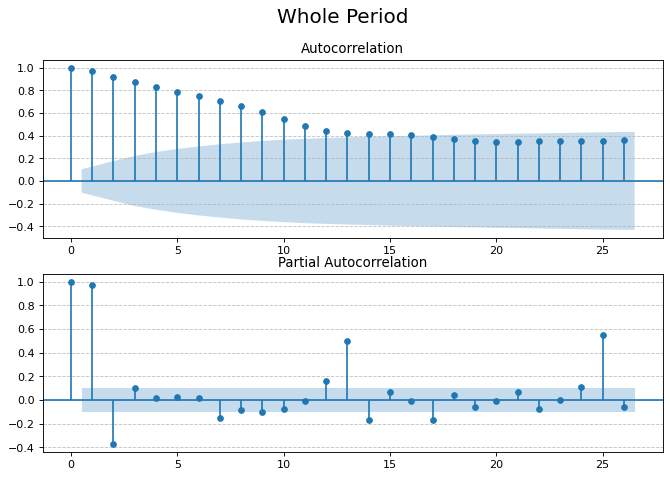

In [71]:
# Autocorrelation Functions (ACF & PACF)
fig, axes = plt.subplots(2, 1, figsize=(10,6.5), dpi= 80)
plt.suptitle('Whole Period', fontsize=18)
tsap.plot_acf(simdf['v_cpi'], ax=axes[0]);
tsap.plot_pacf(simdf['v_cpi'],ax=axes[1]);

for i in range(2): axes[i].grid(axis='y', alpha=0.75, linestyle='--')

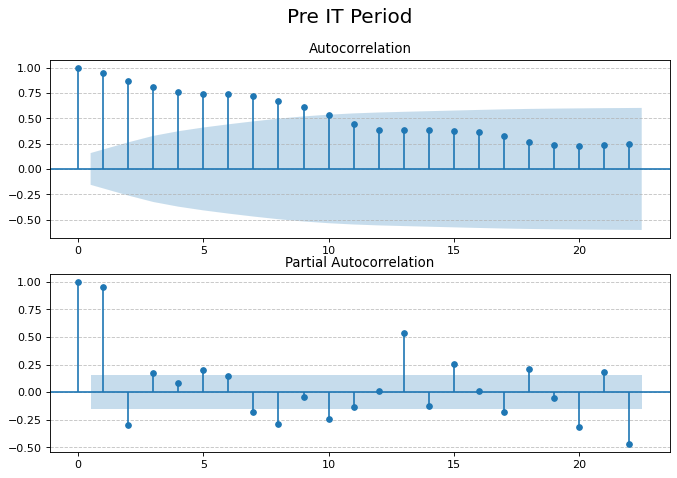

In [70]:
# Autocorrelation Functions (ACF & PACF)
fig, axes = plt.subplots(2, 1, figsize=(10,6.5), dpi= 80)
plt.suptitle('Pre IT Period', fontsize=18)
tsap.plot_acf(predf['v_cpi'], ax=axes[0]);
tsap.plot_pacf(predf['v_cpi'],ax=axes[1]);

for i in range(2): axes[i].grid(axis='y', alpha=0.75, linestyle='--')

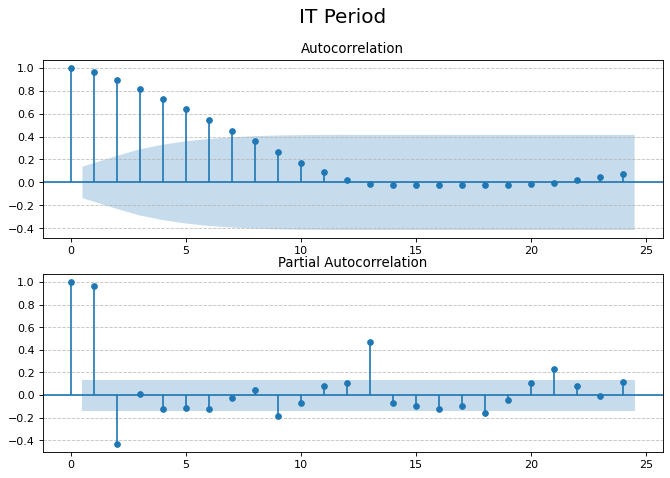

In [69]:
# Autocorrelation Functions (ACF & PACF)
fig, axes = plt.subplots(2, 1, figsize=(10,6.5), dpi= 80)
plt.suptitle('IT Period', fontsize=18)
tsap.plot_acf(itdf['v_cpi'], ax=axes[0]);
tsap.plot_pacf(itdf['v_cpi'],ax=axes[1]);

for i in range(2): axes[i].grid(axis='y', alpha=0.75, linestyle='--')

Taking first differences to make the series stationary

In [93]:
simdf["v_cpi_d"] = simdf['v_cpi'].diff()
simdf["v_cpi_d_vol"] = simdf.v_cpi_d.rolling(12).std()
simdf.dropna(inplace=True)
simdf.head()

,CPI,target,v_cpi,vol_cpi1,IT_reg,v_cpi_d,v_cpi_d_vol
date,,,,,,,
1993-03-01,27.70,7.0,12.009705,0.991456,0.0,-1.298907,1.031382
1993-04-01,28.09,7.0,12.720706,1.006003,0.0,0.711001,1.011281
1993-05-01,28.25,7.0,12.549801,0.993712,0.0,-0.170905,0.999091
1993-06-01,28.94,7.0,14.387352,1.032632,0.0,1.837551,1.083890
1993-07-01,29.62,7.0,15.252918,1.145263,0.0,0.865567,1.044288


In [94]:
predf = simdf.loc['1992-01-01':'2004-12-01']
itdf  = simdf.loc['2005-01-01':'2021-12-01']

In [84]:
# ADF Test for Stationarity on inflation
from statsmodels.tsa.stattools import adfuller
# Whole period
adf = adfuller(simdf['v_cpi_d'])[1] 
print(f"p value:{adf}", ", Series is Stationary" if adf <0.05 else ", Series is Non-Stationary")
# pre IT period
adf = adfuller(predf['v_cpi_d'])[1] 
print(f"p value:{adf}", ", Series is Stationary" if adf <0.05 else ", Series is Non-Stationary")
# it period
adf = adfuller(itdf['v_cpi_d'])[1] 
print(f"p value:{adf}", ", Series is Stationary" if adf <0.05 else ", Series is Non-Stationary")

p value:2.4536629518687153e-11 , Series is Stationary
p value:4.3246935009918976e-05 , Series is Stationary
p value:1.9747838407791828e-07 , Series is Stationary


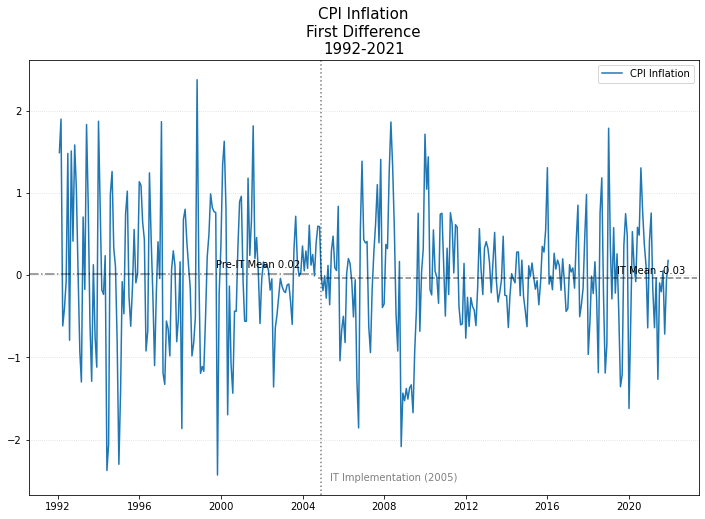

In [89]:
x0 = (simdf.index.get_loc('1992-02-01'))/len(simdf.index)
x1 = (simdf.index.get_loc('2004-12-01'))/len(simdf.index)
x2 = (simdf.index.get_loc('2005-01-01'))/len(simdf.index)
x3 = (simdf.index.get_loc('2021-12-01'))/len(simdf.index)

plt.figure(figsize=(12,8))
plt.title('CPI Inflation\nFirst Difference\n1992-2021', fontsize=15)
plt.plot(simdf.v_cpi_d, label='CPI Inflation')
# plt.ylim([-1.5, 25]) 
# plt.axhline(xmin=x0, xmax=x3, y=mean_all, color='k', linestyle='-')#, label='1995-2021 Mean {:.2f}'.format(np.mean(mean_all)))
plt.axhline(xmin=x0, xmax=x1, y=np.mean(predf['v_cpi_d']), color='k', alpha = 0.5, linestyle='-.')#, label='Pre-IT Mean {:.2f}'.format(np.mean(pre_mean)))
plt.axhline(xmin=x2, xmax=x3, y=np.mean(itdf['v_cpi_d']), color='k', alpha = 0.5, linestyle='--')#, label='IT Mean {:.2f}'.format(np.mean(it_mean)))
plt.axvline(pd.to_datetime('2004-12-01'), color='k', linestyle=':', alpha=0.5)
# plt.plot(simdf.v_cpi.rolling(12).mean(),linestyle='--', label='12-month rolling mean')
plt.text(pd.to_datetime('2005-05-01'),-2.5, 'IT Implementation (2005)', fontsize=10, alpha=0.5)
plt.text(pd.to_datetime('1999-10-01'),np.mean(predf['v_cpi_d'])+0.075, 'Pre-IT Mean {:.2f}'.format(np.mean(predf['v_cpi_d'])), fontsize=10)
plt.text(pd.to_datetime('2019-06-01'),np.mean(itdf['v_cpi_d'])+0.05, 'IT Mean {:.2f}'.format(np.mean(itdf['v_cpi_d'])), fontsize=10)
# plt.text(pd.to_datetime('2018-01-01'),mean_all+0.15, '1995-2021 Mean {:.2f}'.format(np.mean(mean_all)), fontsize=10)
plt.grid(axis='y', linestyle=':', alpha=0.5)
plt.legend()

In [97]:
# Test de diferencia de medias Inflacion
from scipy import stats
t_check=stats.ttest_ind(predf.v_cpi_d.values.tolist(),itdf.v_cpi_d.values.tolist())
t_check
alpha=0.05
if(t_check[1]<alpha):
    print('pre_mean different from it_mean')
    print(t_check)
else:
    print('pre_mean equal to it_mean')
    print(t_check)

pre_mean equal to it_mean
Ttest_indResult(statistic=0.016894812735063863, pvalue=0.9865303254311152)


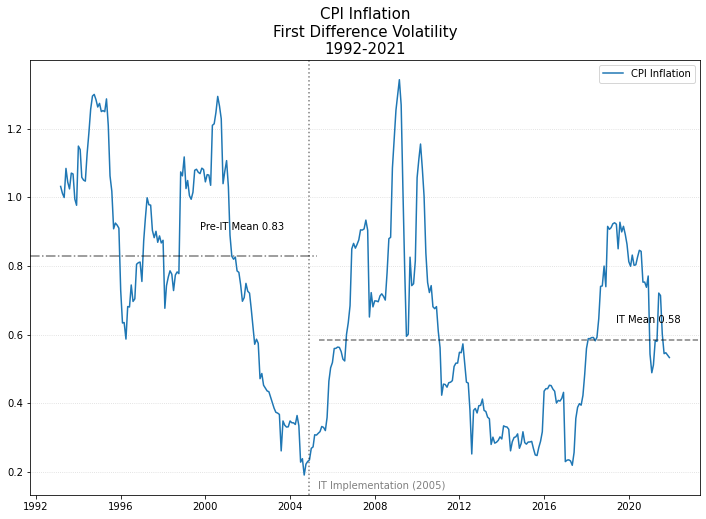

In [104]:
plt.figure(figsize=(12,8))
plt.title('CPI Inflation\nFirst Difference Volatility\n1992-2021', fontsize=15)
plt.plot(simdf.v_cpi_d_vol, label='CPI Inflation')
# plt.ylim([-1.5, 25]) 
# plt.axhline(xmin=x0, xmax=x3, y=mean_all, color='k', linestyle='-')#, label='1995-2021 Mean {:.2f}'.format(np.mean(mean_all)))
plt.axhline(xmin=x0, xmax=x1, y=np.mean(predf['v_cpi_d_vol']), color='k', alpha = 0.5, linestyle='-.')#, label='Pre-IT Mean {:.2f}'.format(np.mean(pre_mean)))
plt.axhline(xmin=x2, xmax=x3, y=np.mean(itdf['v_cpi_d_vol']), color='k', alpha = 0.5, linestyle='--')#, label='IT Mean {:.2f}'.format(np.mean(it_mean)))
plt.axvline(pd.to_datetime('2004-12-01'), color='k', linestyle=':', alpha=0.5)
# plt.plot(simdf.v_cpi.rolling(12).mean(),linestyle='--', label='12-month rolling mean')
plt.text(pd.to_datetime('2005-05-01'),+0.15, 'IT Implementation (2005)', fontsize=10, alpha=0.5)
plt.text(pd.to_datetime('1999-10-01'),np.mean(predf['v_cpi_d_vol'])+0.075, 'Pre-IT Mean {:.2f}'.format(np.mean(predf['v_cpi_d_vol'])), fontsize=10)
plt.text(pd.to_datetime('2019-06-01'),np.mean(itdf['v_cpi_d_vol'])+0.05, 'IT Mean {:.2f}'.format(np.mean(itdf['v_cpi_d_vol'])), fontsize=10)
# plt.text(pd.to_datetime('2018-01-01'),mean_all+0.15, '1995-2021 Mean {:.2f}'.format(np.mean(mean_all)), fontsize=10)
plt.grid(axis='y', linestyle=':', alpha=0.5)
plt.legend()

In [105]:
t_check=stats.ttest_ind(predf.v_cpi_d_vol.values.tolist(),itdf.v_cpi_d_vol.values.tolist())
t_check
alpha=0.05
if(t_check[1]<alpha):
    print('pre_mean different from it_mean')
    print(t_check)
else:
    print('pre_mean equal to it_mean')
    print(t_check)

pre_mean different from it_mean
Ttest_indResult(statistic=8.178377862789965, pvalue=5.6145027889138185e-15)


Benchmark model

as in Kontonikas (2004)

$\pi = \gamma_0 + \gamma_1\pi_{t-1} + \gamma_2\pi_{t-3} + \gamma_3\pi_{t-6} + \gamma_4\pi_{t-12} + u_{1t}$


In [123]:
# lag creation
simdf["v_cpi_l1"] = simdf['v_cpi'].shift()
simdf["v_cpi_l3"] = simdf['v_cpi'].shift(3)
simdf["v_cpi_l6"] = simdf['v_cpi'].shift(6)
simdf["v_cpi_l12"] = simdf['v_cpi'].shift(12)
# simdf.head(15)

predf = simdf.loc['1992-01-01':'2004-12-01']
itdf  = simdf.loc['2005-01-01':'2021-12-01']

In [126]:
# Whole Period
mod1_1 = smf.ols(formula='v_cpi_d ~ v_cpi_l1 + v_cpi_l3 + v_cpi_l6 + v_cpi_l12', data=simdf).fit()
mod1_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                v_cpi_d   R-squared:                       0.110
Model:                            OLS   Adj. R-squared:                  0.099
Method:                 Least Squares   F-statistic:                     10.11
Date:                Wed, 29 Jun 2022   Prob (F-statistic):           9.84e-08
Time:                        12:13:53   Log-Likelihood:                -356.16
No. Observations:                 334   AIC:                             722.3
Df Residuals:                     329   BIC:                             741.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3548      0.100      3.537      0.000       0.157       0.552
v_cpi_l1       0.0985      0.033      2.981      0.003       0.034       0.164
v_cpi_l3      -0.1809      0.041     -4.425      0.000      -0.261      -0.100
v_cpi_l6       0.0557      0.031      1.819      0.070      -0.005       0.116
v_cpi_l12     -0.0348      0.019     -1.865      0.063      -0.072       0.002
==============================================================================
Omnibus:                        9.674   Durbin-Watson:                   1.554
Prob(Omnibus):                  0.008   Jarque-Bera (JB):               17.024
Skew:                           0.098   Prob(JB):                     0.000201
Kurtosis:                       4.088   Cond. No.                         35.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [127]:
# Pre IT Period
mod1_2 = smf.ols(formula='v_cpi_d ~ v_cpi_l1 + v_cpi_l3 + v_cpi_l6 + v_cpi_l12', data=predf).fit()
mod1_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                v_cpi_d   R-squared:                       0.237
Model:                            OLS   Adj. R-squared:                  0.213
Method:                 Least Squares   F-statistic:                     9.705
Date:                Wed, 29 Jun 2022   Prob (F-statistic):           7.21e-07
Time:                        12:14:11   Log-Likelihood:                -144.01
No. Observations:                 130   AIC:                             298.0
Df Residuals:                     125   BIC:                             312.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.8400      0.248      3.391      0.001       0.350       1.330
v_cpi_l1      -0.0516      0.053     -0.975      0.331      -0.156       0.053
v_cpi_l3      -0.1614      0.059     -2.742      0.007      -0.278      -0.045
v_cpi_l6       0.2297      0.049      4.710      0.000       0.133       0.326
v_cpi_l12     -0.1240      0.036     -3.443      0.001      -0.195      -0.053
==============================================================================
Omnibus:                        1.913   Durbin-Watson:                   1.498
Prob(Omnibus):                  0.384   Jarque-Bera (JB):                1.437
Skew:                           0.155   Prob(JB):                        0.488
Kurtosis:                       3.411   Cond. No.                         64.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [128]:
# IT Period
mod1_3 = smf.ols(formula='v_cpi_d ~ v_cpi_l1 + v_cpi_l3 + v_cpi_l6 + v_cpi_l12', data=itdf).fit()
mod1_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                v_cpi_d   R-squared:                       0.174
Model:                            OLS   Adj. R-squared:                  0.157
Method:                 Least Squares   F-statistic:                     10.45
Date:                Wed, 29 Jun 2022   Prob (F-statistic):           1.06e-07
Time:                        12:14:33   Log-Likelihood:                -190.83
No. Observations:                 204   AIC:                             391.7
Df Residuals:                     199   BIC:                             408.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3501      0.117      2.998      0.003       0.120       0.580
v_cpi_l1       0.1296      0.043      3.045      0.003       0.046       0.214
v_cpi_l3      -0.1343      0.056     -2.396      0.017      -0.245      -0.024
v_cpi_l6      -0.0635      0.038     -1.651      0.100      -0.139       0.012
v_cpi_l12     -0.0053      0.022     -0.239      0.811      -0.049       0.038
==============================================================================
Omnibus:                        5.698   Durbin-Watson:                   1.585
Prob(Omnibus):                  0.058   Jarque-Bera (JB):                6.201
Skew:                           0.253   Prob(JB):                       0.0450
Kurtosis:                       3.689   Cond. No.                         29.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
# estimate model:
# mr_mod = smf.ols(formula='colGPA ~ hsGPA + ACT + alcohol', data=df)

In [38]:
# df_m =  pd.read_csv('data/monthly_data.csv', delimiter=';')
# df_m.index = pd.to_datetime(df_m.month, format='%d/%m/%Y')
# df_m = df_m.drop("month", axis = 1)

# # IT regime dummy variable
# df_m['IT_reg'] = np.zeros(len(df_m))
# df_m['IT_reg']['2005-01-01':] = 1 

# df_m['v_cpi'] = df_m.cpi.pct_change(12)*100
# df_m['vol_cpi1'] = df_m.v_cpi.rolling(12).std()
# df_m['v_cpi_usa'] = df_m.cpi_usa.pct_change(12)*100
# df_m['output'] = df_m.imae_tc.pct_change(12)*100
# df_m['v_ner_gt'] = df_m.ner_gt.pct_change(12)*100
# df_m.tail()

# df_m.head()

In [34]:
# DataFrame Manipulation for Quarter-wise and Year-wise boxplots
# df = df_m[12:].copy()
# df.reset_index(inplace=True)
# df['year'] = [d.year for d in df.month]
# df['mm'] = [d.strftime('%b') for d in df.month]
# years = df['year'].unique()
# df.head()

In [35]:
# Draw Plot
# fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
# plt.figtext(0.125, .01, 'Source: Banco de Guatemala', ha='left', fontsize=11)
# sns.boxplot(x='year', y='v_cpi', data=df, ax=axes[0]) #Year-wise Boxplot (Trend)
# axes[0].set_xticklabels(axes[0].get_xticklabels(),rotation = 45)
# sns.boxplot(x='mm', y='v_cpi', data=df) #Quarter-wise Boxplot (Seasonality)
# axes[1].set_xlabel('Month', fontsize=11)
# # Set Title
# plt.suptitle('Figure 2', y=1.05, fontsize=18)
# axes[0].set_title('Year-wise Box Plot\n(Trend)', fontsize=14); 
# axes[1].set_title('Quarter-wise Box Plot\n(Seasonality)', fontsize=14)
# plt.show()

In [36]:
# # Additive Decomposition
# plt.rcParams['figure.figsize'] = (12, 8);
# a = tsa.seasonal_decompose(df_m['v_cpi'][12:],model='additive', extrapolate_trend='freq').plot()
# plt.suptitle('Figure 3\nAdditive Decomposition', x = 0.525, y = 1.055, fontsize=20)
# for i in range(len(a.axes)):
#     a.axes[i].grid(axis='x', alpha=0.75, linestyle=':')
#     a.axes[i].grid(axis='y', alpha=0.75, linestyle=':')
# plt.show()